# Overview

We will use a rolling average model, with a time period of 30 days, for the Sonona and Austin intake and outcomes data. I originally did a 7 day rolling average, but the large variability in the data produces a large variability in rolling average. Our baseline model will be the assumption that 2024 will be similar to 2023. Most shelter statistics we found are year-over-year comparisons, so we create a prediction by taking the rolling averages for 2023 as the predicted values for 2024. 

# Rolling average forecast

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from seaborn import set_style
from sklearn.metrics import mean_squared_error

set_style("whitegrid")

In [115]:
#read in shelter data 
shelter_data = pd.read_csv("../../main_data/CleanedDataOnePlace.csv")

# Convert 'Date' column to datetime objects
shelter_data['Date'] = pd.to_datetime(shelter_data['Date'])

/var/folders/rl/kqt6tbv90l9_pwc4927vdb340000gn/T/ipykernel_6091/1454077153.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  shelter_data['Date'] = pd.to_datetime(shelter_data['Date'])


First, we will plot the totals and rolling averages, before doing any other modeling:

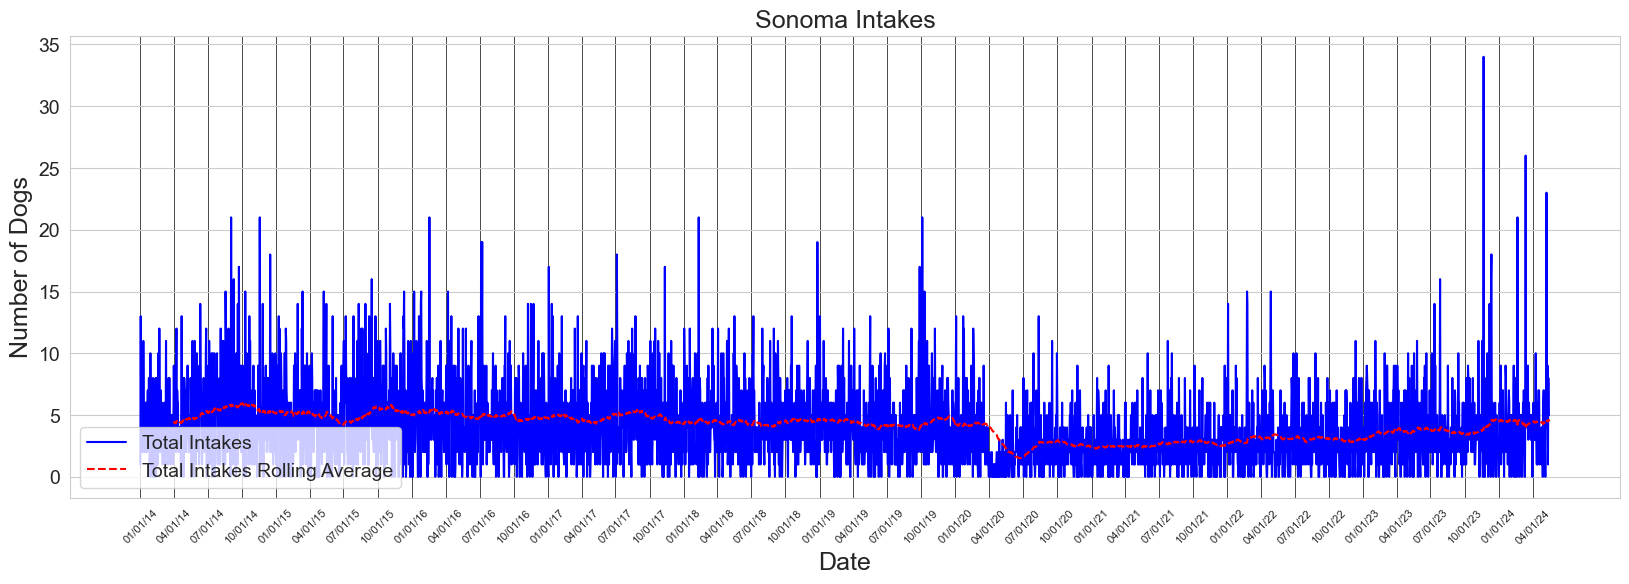

In [162]:
plt.figure(figsize=(20,6))


plt.plot(shelter_data.Date, 
         shelter_data.SonomaIntakeTotals,
         'b',
         label="Total Intakes")

plt.plot(shelter_data.Date, 
         shelter_data.SonomaIntakeTotals.rolling(90, closed='left').mean(),
         'r--',
         label="Total Intakes Rolling Average")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Sonoma Intakes", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/14', end='5/31/24', freq='QS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

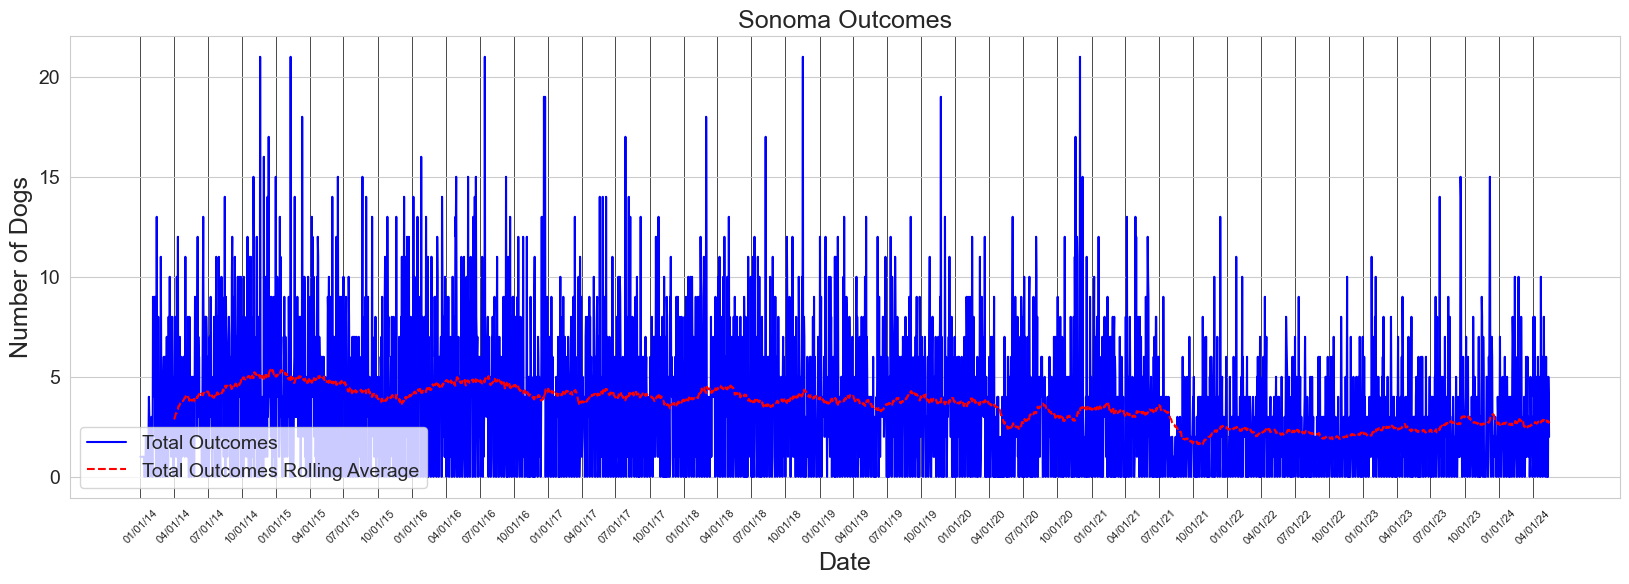

In [163]:
plt.figure(figsize=(20,6))


plt.plot(shelter_data.Date, 
         shelter_data.SonomaOutcomeTotals,
         'b',
         label="Total Outcomes")

plt.plot(shelter_data.Date, 
         shelter_data.SonomaOutcomeTotals.rolling(90, closed='left').mean(),
         'r--',
         label="Total Outcomes Rolling Average")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Sonoma Outcomes", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/14', end='5/31/24', freq='QS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

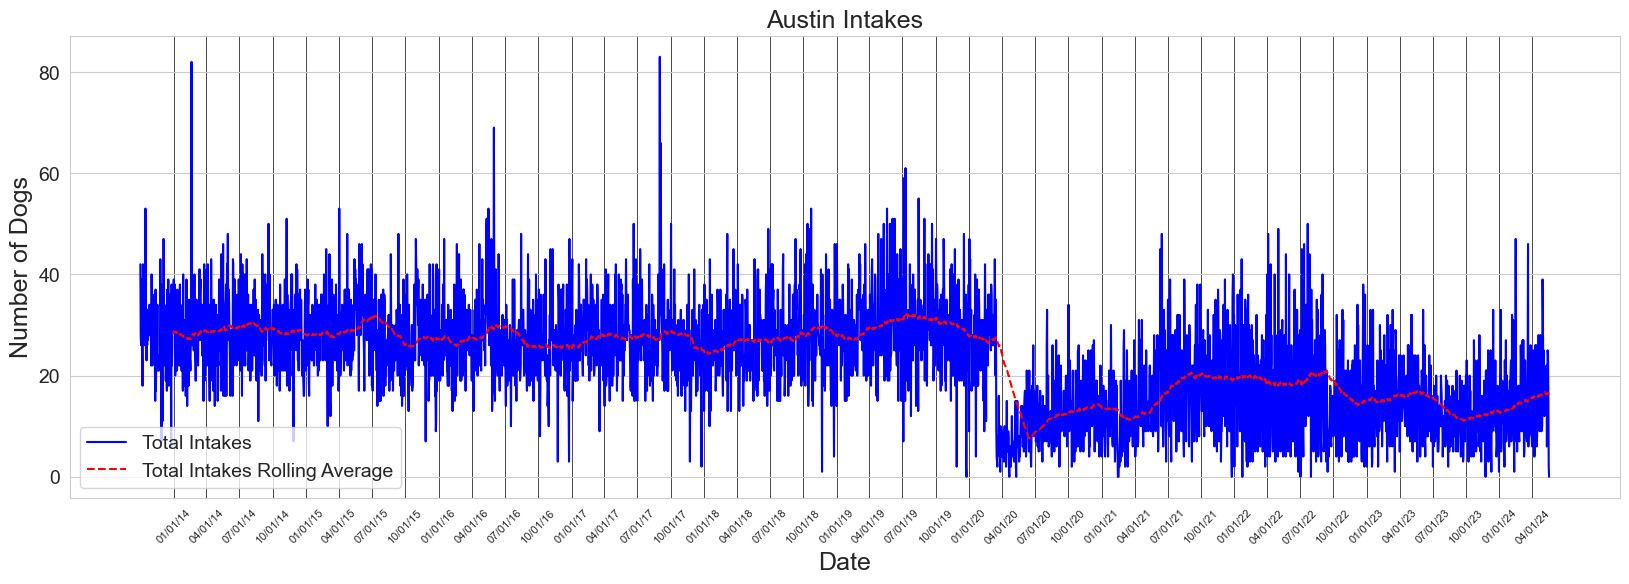

In [165]:
plt.figure(figsize=(20,6))


plt.plot(shelter_data.Date, 
         shelter_data.AustinIntakeTotal,
         'b',
         label="Total Intakes")

plt.plot(shelter_data.Date, 
         shelter_data.AustinIntakeTotal.rolling(90, closed='left').mean(),
         'r--',
         label="Total Intakes Rolling Average")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Austin Intakes", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/14', end='5/31/24', freq='QS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

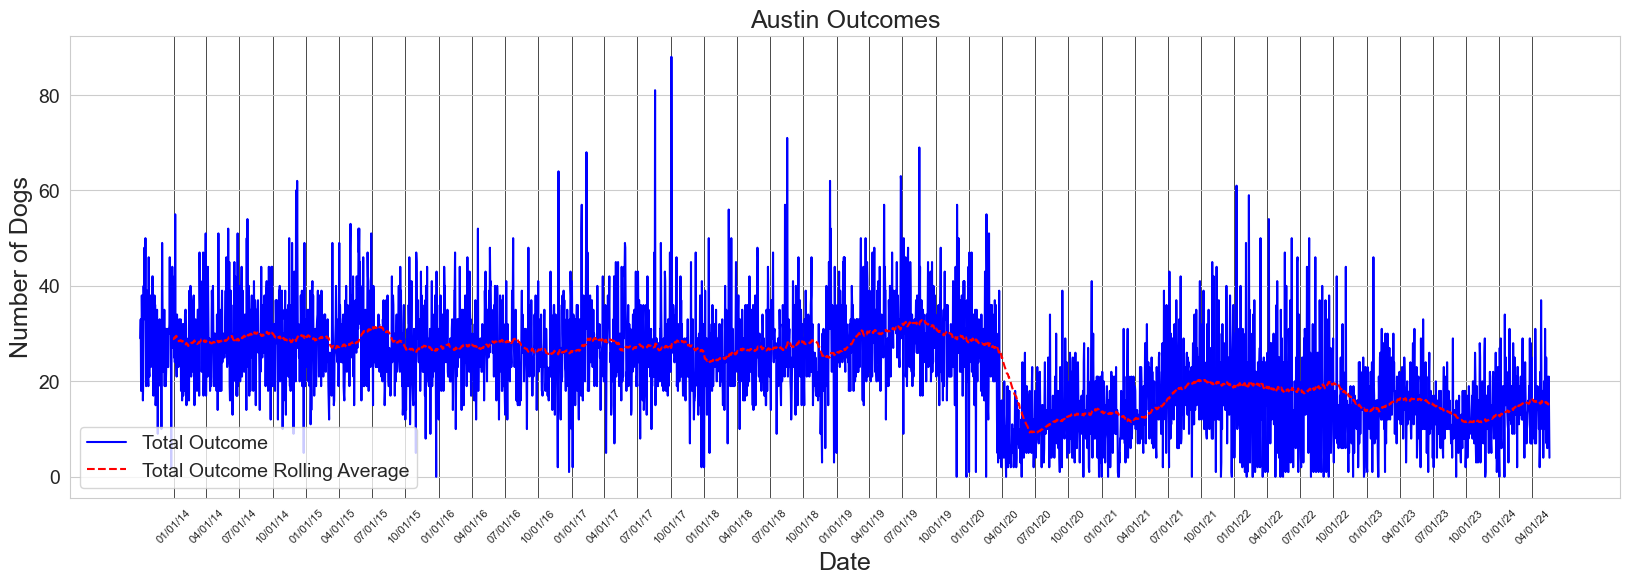

In [166]:
plt.figure(figsize=(20,6))


plt.plot(shelter_data.Date, 
         shelter_data.AustinOutcomeTotal,
         'b',
         label="Total Outcome")

plt.plot(shelter_data.Date, 
         shelter_data.AustinOutcomeTotal.rolling(90, closed='left').mean(),
         'r--',
         label="Total Outcome Rolling Average")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Austin Outcomes", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/14', end='5/31/24', freq='QS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

In [117]:
# find the index with Jan 1, 2024

first_day24 = shelter_data[shelter_data['Date'] == '2024-01-01'].index[0]


In [118]:
shelter_train = shelter_data.iloc[:first_day24].copy()
shelter_test = shelter_data.iloc[first_day24:].copy()

In [119]:
# checking our split worked
print(shelter_train)

           Date  SonomaIntakeTotals  SonomaOutcomeTotals  SonomaDifferences  \
0    2013-10-01                 NaN                  NaN                NaN   
1    2013-10-02                 NaN                  NaN                NaN   
2    2013-10-03                 NaN                  NaN                NaN   
3    2013-10-04                 NaN                  NaN                NaN   
4    2013-10-05                 NaN                  NaN                NaN   
...         ...                 ...                  ...                ...   
3739 2023-12-27                 2.0                  1.0                1.0   
3740 2023-12-28                 2.0                  1.0                1.0   
3741 2023-12-29                 2.0                  4.0               -2.0   
3742 2023-12-30                 3.0                  3.0                0.0   
3743 2023-12-31                 2.0                  0.0                2.0   

      SonomaRatio  Sonoma_intake_stray_abandoned  \

In [120]:
print(shelter_test)

           Date  SonomaIntakeTotals  SonomaOutcomeTotals  SonomaDifferences  \
3744 2024-01-01                 0.0                  0.0                0.0   
3745 2024-01-02                 5.0                  1.0                4.0   
3746 2024-01-03                 6.0                  3.0                3.0   
3747 2024-01-04                 5.0                  7.0               -2.0   
3748 2024-01-05                 6.0                  2.0                4.0   
...         ...                 ...                  ...                ...   
3878 2024-05-14                 5.0                  4.0                1.0   
3879 2024-05-15                 5.0                  2.0                3.0   
3880 2024-05-16                 NaN                  NaN                NaN   
3881 2024-05-17                 NaN                  NaN                NaN   
3882 2024-05-18                 NaN                  NaN                NaN   

      SonomaRatio  Sonoma_intake_stray_abandoned  \

## Sonoma 


### Intakes

We will define a rolling average on Stray Abandoned, Owner Surrender, Public Assistance, and Other Intake, as well as total intakes. We believe these different categories are useful to shelters, as they may require different staffing or resources.

In [121]:
# Sonoma data actually starts Jan 1, 2014
# Let's further refine the test data

# find the index with Jan 1, 2014

first_day_sonoma = shelter_data[shelter_data['Date'] == '2014-01-01'].index[0]

In [122]:
shelter_train_sonoma = shelter_data.iloc[first_day_sonoma:first_day24].copy()
print(shelter_train_sonoma)

           Date  SonomaIntakeTotals  SonomaOutcomeTotals  SonomaDifferences  \
92   2014-01-01                 1.0                  1.0                0.0   
93   2014-01-02                13.0                  1.0               12.0   
94   2014-01-03                 4.0                  1.0                3.0   
95   2014-01-04                 8.0                  1.0                7.0   
96   2014-01-05                 2.0                  1.0                1.0   
...         ...                 ...                  ...                ...   
3739 2023-12-27                 2.0                  1.0                1.0   
3740 2023-12-28                 2.0                  1.0                1.0   
3741 2023-12-29                 2.0                  4.0               -2.0   
3742 2023-12-30                 3.0                  3.0                0.0   
3743 2023-12-31                 2.0                  0.0                2.0   

      SonomaRatio  Sonoma_intake_stray_abandoned  \

In [123]:
Sonoma_trained_intake_averages = pd.DataFrame({'Date':shelter_train_sonoma['Date'],
                  'Sonoma_intake_stray_abandoned':shelter_train_sonoma.Sonoma_intake_stray_abandoned,
                  'stray_rolling_avg':shelter_train_sonoma.Sonoma_intake_stray_abandoned.rolling(90,
                                                                closed='left').mean(),
                'Sonoma_intake_owner_surrender':shelter_train_sonoma.Sonoma_intake_owner_surrender,
                  'owner_surrender_rolling_avg':shelter_train_sonoma.Sonoma_intake_owner_surrender.rolling(90,
                                                                closed='left').mean(),
                'Sonoma_intake_public_assist':shelter_train_sonoma.Sonoma_intake_public_assist,
                  'public_assist_rolling_avg':shelter_train_sonoma.Sonoma_intake_public_assist.rolling(90,
                                                                closed='left').mean(),
                'Sonoma_intake_other':shelter_train_sonoma.Sonoma_intake_other_i,
                  'other_intake_rolling_avg':shelter_train_sonoma.Sonoma_intake_other_i.rolling(90,
                                                                closed='left').mean(),
                'SonomaIntakeTotals':shelter_train_sonoma.SonomaIntakeTotals,
                  'SonomaIntakeTotals_rolling_avg':shelter_train_sonoma.SonomaIntakeTotals.rolling(90,
                                                                closed='left').mean()
                                                                }).reset_index(drop=True)

Let's just plot just the rolling averages

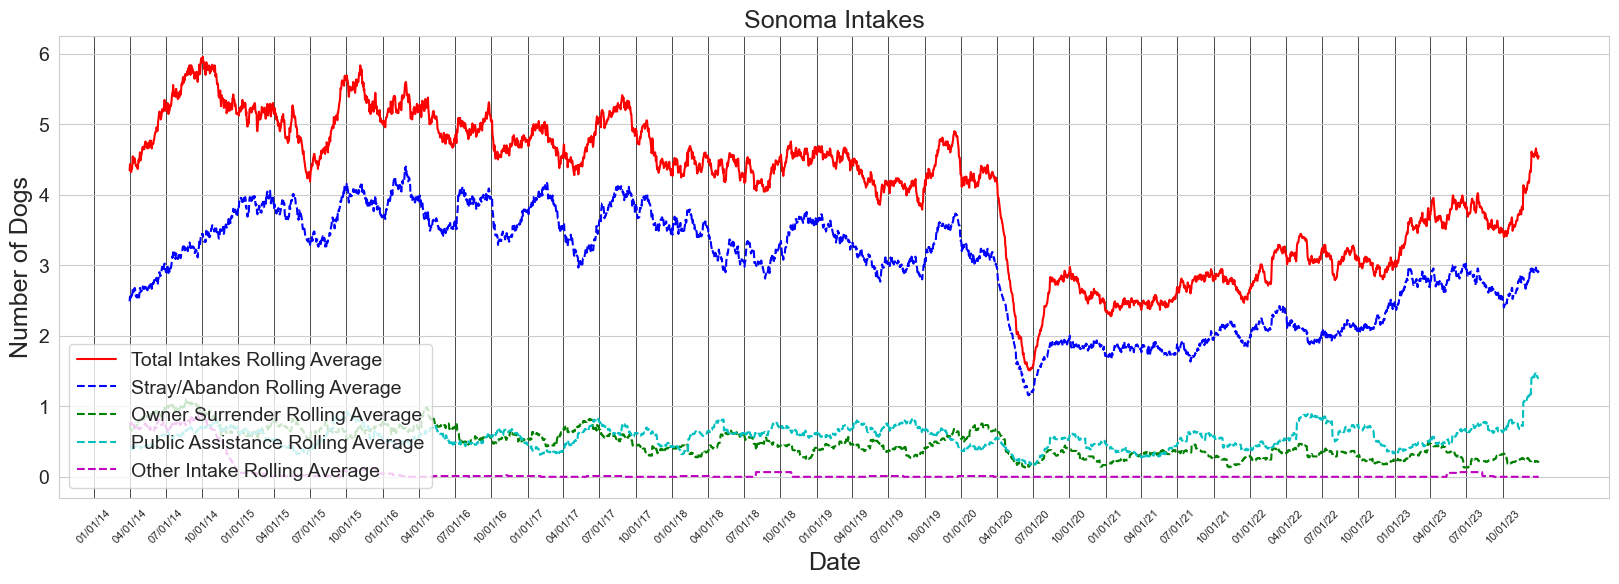

In [124]:
plt.figure(figsize=(20,6))

plt.plot(Sonoma_trained_intake_averages.Date, 
         Sonoma_trained_intake_averages.SonomaIntakeTotals_rolling_avg,
         'r',
         label="Total Intakes Rolling Average")

plt.plot(Sonoma_trained_intake_averages.Date, 
         Sonoma_trained_intake_averages.stray_rolling_avg,
         'b--',
         label="Stray/Abandon Rolling Average")

plt.plot(Sonoma_trained_intake_averages.Date, 
         Sonoma_trained_intake_averages.owner_surrender_rolling_avg,
         'g--',
         label="Owner Surrender Rolling Average")

plt.plot(Sonoma_trained_intake_averages.Date, 
         Sonoma_trained_intake_averages.public_assist_rolling_avg,
         'c--',
         label="Public Assistance Rolling Average")

plt.plot(Sonoma_trained_intake_averages.Date, 
         Sonoma_trained_intake_averages.other_intake_rolling_avg,
         'm--',
         label="Other Intake Rolling Average")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Sonoma Intakes", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/14', end='12/31/23', freq='QS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

#### Intake Forecast

We will take the 2023 rolling averages and use those as the prediction for 2024. Since 2024 is a leap year, we will duplicate the values from February 28 and the values for February 29.

In [125]:
# copy the 2023 data
columns_to_copy = ['Date', 'stray_rolling_avg','owner_surrender_rolling_avg','public_assist_rolling_avg','other_intake_rolling_avg','SonomaIntakeTotals_rolling_avg']

# Find first day 2023

first_day23 = Sonoma_trained_intake_averages[Sonoma_trained_intake_averages['Date'] == '2023-01-01'].index[0]

rows2023 = Sonoma_trained_intake_averages.loc[first_day23:, columns_to_copy].copy()

# add one year to the dates

rows2023['Date'] = rows2023['Date'] + pd.DateOffset(years=1)

# add in leap date
index_feb28 = rows2023[rows2023['Date'] == '2024-02-28'].index[0]
# Duplicate the row with the date '2024-02-28' and set the date to '2024-02-29'
feb29 = rows2023.loc[index_feb28].copy()
feb29['Date'] += pd.Timedelta(days=1)
rows2024 = pd.concat([rows2023.loc[:index_feb28], pd.DataFrame([feb29]), rows2023.loc[index_feb28 + 1:]])

# merge into original list

Sonoma_intake_averages = pd.concat([Sonoma_trained_intake_averages, rows2024], ignore_index=True)

In [126]:
print(Sonoma_intake_averages)

           Date  Sonoma_intake_stray_abandoned  stray_rolling_avg  \
0    2014-01-01                            1.0                NaN   
1    2014-01-02                            6.0                NaN   
2    2014-01-03                            2.0                NaN   
3    2014-01-04                            4.0                NaN   
4    2014-01-05                            2.0                NaN   
...         ...                            ...                ...   
4013 2024-12-27                            NaN           2.933333   
4014 2024-12-28                            NaN           2.922222   
4015 2024-12-29                            NaN           2.900000   
4016 2024-12-30                            NaN           2.911111   
4017 2024-12-31                            NaN           2.922222   

      Sonoma_intake_owner_surrender  owner_surrender_rolling_avg  \
0                               0.0                          NaN   
1                               4.0

In [127]:
# Find first day 2024

first_day24 = Sonoma_intake_averages[Sonoma_intake_averages['Date'] == '2024-01-01'].index[0]

# Check it worked
print(Sonoma_intake_averages.Date.iloc[first_day24])

2024-01-01 00:00:00


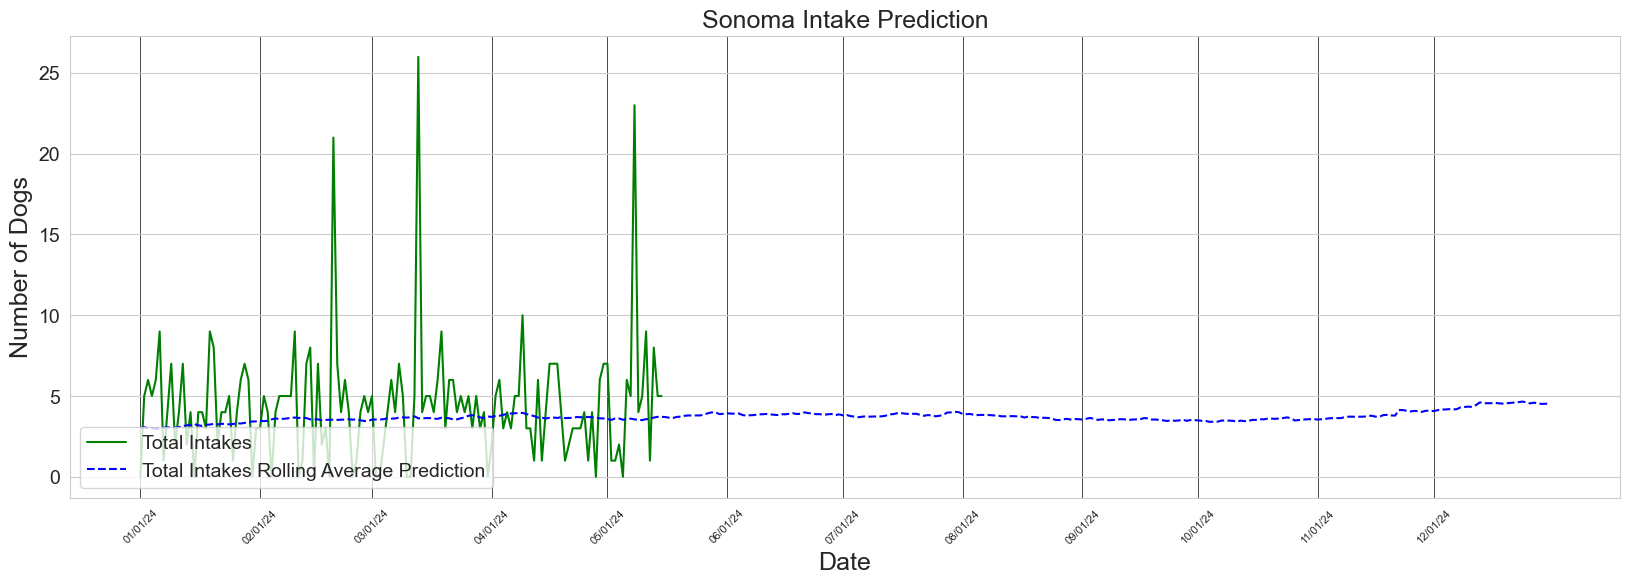

In [128]:
plt.figure(figsize=(20,6))


plt.plot(shelter_test.Date, 
         shelter_test.SonomaIntakeTotals,
         'g',
         label="Total Intakes")

plt.plot(Sonoma_intake_averages.Date[first_day24:], 
         Sonoma_intake_averages.SonomaIntakeTotals_rolling_avg[first_day24:],
         'b--',
         label="Total Intakes Rolling Average Prediction")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Sonoma Intake Prediction", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/24', end='12/31/24', freq='MS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

Since we are using root mean-squared error (RMSE) to calculate the error for the other models, we will do the same here. The since the prediction for 2024 is the rolling average values data from 2023, but we only have data through May 15, 2024, we need to find the end of the real data.

In [129]:
# There are a few more rows for Austin than Sonoma
# We will find the last nonempty value for SonamaIntakeTotals
last_nonempty_SononmaIntakeTotals = shelter_test.SonomaIntakeTotals.last_valid_index()

print(last_nonempty_SononmaIntakeTotals)
# Now find the last date

last_date_Sonoma_data = shelter_test.Date[last_nonempty_SononmaIntakeTotals]

print(last_date_Sonoma_data)

# Find the index of the same day in the rolling average data
index_last_date_Sonoma_avg = Sonoma_intake_averages.index[Sonoma_intake_averages['Date'] == last_date_Sonoma_data][0]

print(index_last_date_Sonoma_avg)

3879
2024-05-15 00:00:00
3787


In [130]:
# Make a list of actual intake totals
# First we check that we are getting the correct dates
SonomaIntakeRealDates = shelter_test.Date.loc[:last_nonempty_SononmaIntakeTotals]
print(SonomaIntakeRealDates)

SonomaIntakeTotals_real = pd.DataFrame(shelter_test.SonomaIntakeTotals.loc[:last_nonempty_SononmaIntakeTotals], columns=['SonomaIntakeTotals'])


# Make a list of the predicted intake totals
# First we check that we are getting the correct dates
SonomaIntakePredictedDates = Sonoma_intake_averages.Date[first_day24:index_last_date_Sonoma_avg + 1]

print(SonomaIntakePredictedDates)

# Then we create the predicted intake totals
SonomaIntakeTotals_predicted = pd.DataFrame(Sonoma_intake_averages.SonomaIntakeTotals_rolling_avg[first_day24:index_last_date_Sonoma_avg + 1], columns=['SonomaIntakeTotals_rolling_avg'])

# Reset indices
SonomaIntakeTotals_real.reset_index(drop=True, inplace=True)
SonomaIntakeTotals_predicted.reset_index(drop=True, inplace=True)

3744   2024-01-01
3745   2024-01-02
3746   2024-01-03
3747   2024-01-04
3748   2024-01-05
          ...    
3875   2024-05-11
3876   2024-05-12
3877   2024-05-13
3878   2024-05-14
3879   2024-05-15
Name: Date, Length: 136, dtype: datetime64[ns]
3652   2024-01-01
3653   2024-01-02
3654   2024-01-03
3655   2024-01-04
3656   2024-01-05
          ...    
3783   2024-05-11
3784   2024-05-12
3785   2024-05-13
3786   2024-05-14
3787   2024-05-15
Name: Date, Length: 136, dtype: datetime64[ns]


In [131]:
# Now to calculate the RSME

# Record Rolling Average rmse's
Sonoma_intake_rolling_ave_rmses = np.zeros(len(SonomaIntakeTotals_predicted))

for i in range(len(SonomaIntakeTotals_predicted)):
    df_tt = SonomaIntakeTotals_predicted.iloc[i]
    df_ho = SonomaIntakeTotals_real.iloc[i]
    
    Sonoma_intake_rolling_ave_rmses[i] = np.sqrt(mean_squared_error(df_ho, df_tt))

print("Sonoma Intake Rolling Average: \n", Sonoma_intake_rolling_ave_rmses.mean(axis=0))


Sonoma Intake Rolling Average: 
 2.432516339869281


NRMSE's of models used (NRMSE = RMSE/(max - min)):

In [132]:
Sonoma_intake_monthly_maxmindiff = (SonomaIntakeTotals_real.max(axis=0) - SonomaIntakeTotals_real.min(axis=0))

print("Sonoma Intake Rolling Average: \n", Sonoma_intake_rolling_ave_rmses.mean(axis=0)/Sonoma_intake_monthly_maxmindiff)


Sonoma Intake Rolling Average: 
 SonomaIntakeTotals    0.093558
dtype: float64


### Outcomes

In [133]:
Sonoma_trained_outcome_averages = pd.DataFrame({'Date':shelter_train_sonoma['Date'],
                  'Sonoma_outcome_euthanised':shelter_train_sonoma.Sonoma_outcome_euthanised,
                  'euthanised_rolling_avg':shelter_train_sonoma.Sonoma_outcome_euthanised.rolling(90,
                                                                closed='left').mean(),
                'Sonoma_outcome_adoption':shelter_train_sonoma.Sonoma_outcome_adoption,
                  'adoption_rolling_avg':shelter_train_sonoma.Sonoma_outcome_adoption.rolling(90,
                                                                closed='left').mean(),
                'Sonoma_outcome_return_to_owner':shelter_train_sonoma.Sonoma_outcome_return_to_owner,
                  'return_to_owner_rolling_avg':shelter_train_sonoma.Sonoma_outcome_return_to_owner.rolling(90,
                                                                closed='left').mean(),
                'Sonoma_outcome_unintended':shelter_train_sonoma.Sonoma_outcome_unintended,
                  'outcome_unintended_rolling_avg':shelter_train_sonoma.Sonoma_outcome_unintended.rolling(90,
                                                                closed='left').mean(),
                'Sonoma_outcome_other':shelter_train_sonoma.Sonoma_outcome_other,
                  'outcome_other_rolling_avg':shelter_train_sonoma.Sonoma_outcome_other.rolling(90,
                                                                closed='left').mean(),
                'SonomaOutcomeTotals':shelter_train_sonoma.SonomaOutcomeTotals,
                  'SonomaOutcomeTotals_rolling_avg':shelter_train_sonoma.SonomaOutcomeTotals.rolling(90,
                                                                closed='left').mean()
                                                                })

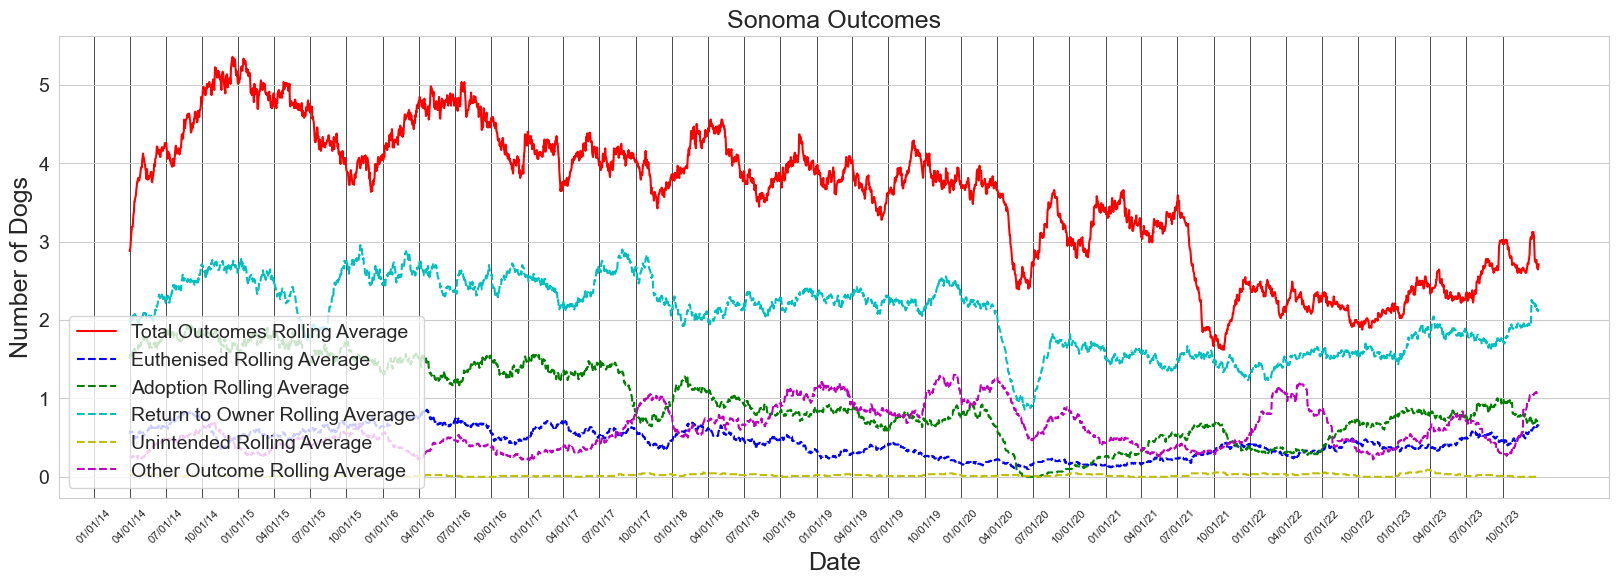

In [134]:
plt.figure(figsize=(20,6))

plt.plot(Sonoma_trained_outcome_averages.Date, 
         Sonoma_trained_outcome_averages.SonomaOutcomeTotals_rolling_avg,
         'r',
         label="Total Outcomes Rolling Average")

plt.plot(Sonoma_trained_outcome_averages.Date, 
         Sonoma_trained_outcome_averages.euthanised_rolling_avg,
         'b--',
         label="Euthenised Rolling Average")

plt.plot(Sonoma_trained_outcome_averages.Date, 
         Sonoma_trained_outcome_averages.adoption_rolling_avg,
         'g--',
         label="Adoption Rolling Average")

plt.plot(Sonoma_trained_outcome_averages.Date, 
         Sonoma_trained_outcome_averages.return_to_owner_rolling_avg,
         'c--',
         label="Return to Owner Rolling Average")

plt.plot(Sonoma_trained_outcome_averages.Date, 
         Sonoma_trained_outcome_averages.outcome_unintended_rolling_avg,
         'y--',
         label="Unintended Rolling Average")

plt.plot(Sonoma_trained_outcome_averages.Date, 
         Sonoma_trained_outcome_averages.outcome_other_rolling_avg,
         'm--',
         label="Other Outcome Rolling Average")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Sonoma Outcomes", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/14', end='12/31/23', freq='QS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

#### Outcomes Forecast

We will repeat the same analysis as the intakes: duplicating the 2023 rolling averages as the prediction for 2024

In [135]:
# copy the 2023 data
columns_to_copy = ['Date', 'euthanised_rolling_avg',
                  'adoption_rolling_avg',
                  'return_to_owner_rolling_avg',
                  'outcome_unintended_rolling_avg',
                  'outcome_other_rolling_avg',
                  'SonomaOutcomeTotals_rolling_avg']

rows2023 = Sonoma_trained_outcome_averages.loc[first_day23:, columns_to_copy].copy()

# add one year to the dates

rows2023['Date'] = rows2023['Date'] + pd.DateOffset(years=1)

# add in leap date
index_feb28 = rows2023[rows2023['Date'] == '2024-02-28'].index[0]
# Duplicate the row with the date '2024-02-28' and set the date to '2024-02-29'
feb29 = rows2023.loc[index_feb28].copy()
feb29['Date'] += pd.Timedelta(days=1)
rows2024 = pd.concat([rows2023.loc[:index_feb28], pd.DataFrame([feb29]), rows2023.loc[index_feb28 + 1:]])

# merge into original list

Sonoma_outcome_averages = pd.concat([Sonoma_trained_outcome_averages, rows2024], ignore_index=True)

In [136]:
# Find first day 2024

first_day24 = Sonoma_outcome_averages[Sonoma_outcome_averages['Date'] == '2024-01-01'].index[0]

# Check it worked
print(Sonoma_outcome_averages.Date.iloc[first_day24])

2024-01-01 00:00:00


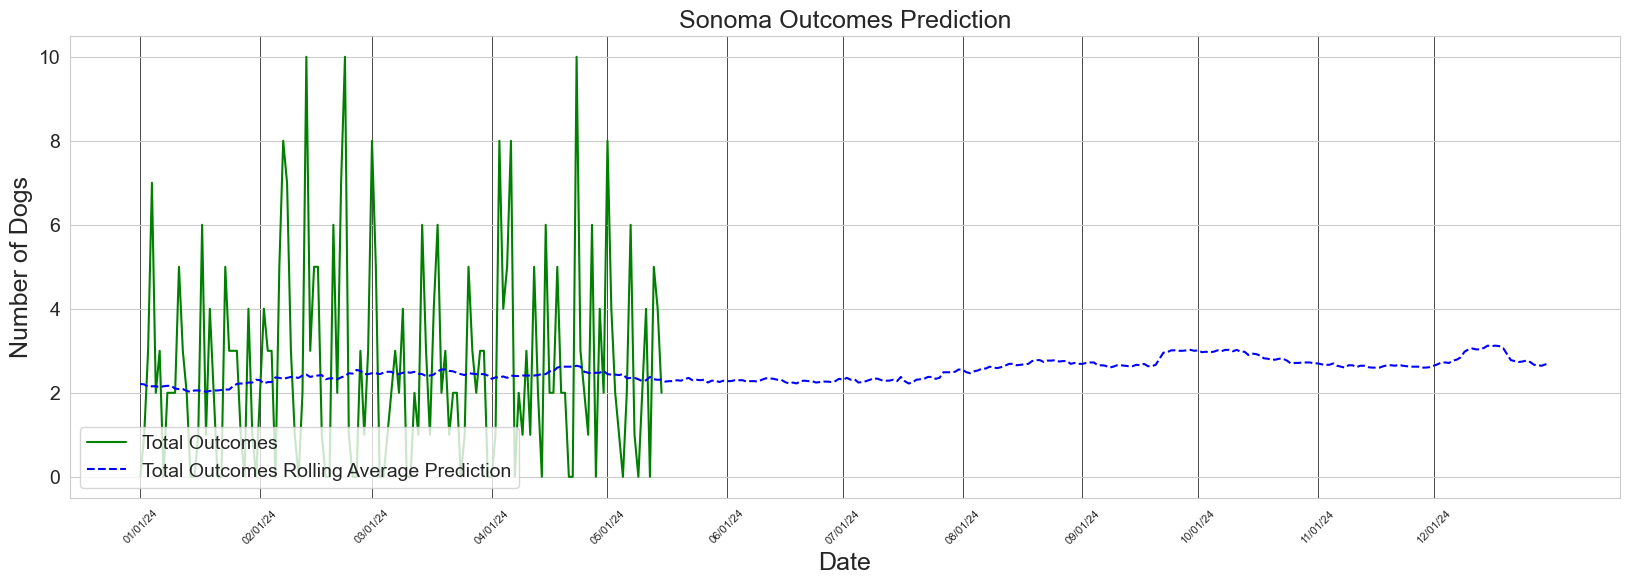

In [137]:
plt.figure(figsize=(20,6))


plt.plot(shelter_test.Date, 
         shelter_test.SonomaOutcomeTotals,
         'g',
         label="Total Outcomes")

plt.plot(Sonoma_outcome_averages.Date[first_day24:], 
         Sonoma_outcome_averages.SonomaOutcomeTotals_rolling_avg[first_day24:],
         'b--',
         label="Total Outcomes Rolling Average Prediction")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Sonoma Outcomes Prediction", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/24', end='12/31/24', freq='MS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

Since we are using root mean-squared error (RMSE) to calculate the error for the other models, we will do the same here. The since the prediction for 2024 is the rolling average values data from 2023, but we only have data through May 15, 2024, we need to find the end of the real data.


In [138]:
# There are a few more rows for Austin than Sonoma
# We will find the last nonempty value for SonamaIntakeTotals
last_nonempty_SononmaOutcomeTotals = shelter_test.SonomaOutcomeTotals.last_valid_index()

# Now find the last date

last_date_Sonoma_data = shelter_test.Date[last_nonempty_SononmaOutcomeTotals]

# Find the index of the same day in the rolling average data
index_last_date_Sonoma_avg = Sonoma_outcome_averages.index[Sonoma_outcome_averages['Date'] == last_date_Sonoma_data][0]

# Make a list of actual intake totals
SonomaOutcomeRealDates = shelter_test.Date.loc[:last_nonempty_SononmaOutcomeTotals]

SonomaOutcomeTotals_real = pd.DataFrame(shelter_test.SonomaOutcomeTotals.loc[:last_nonempty_SononmaOutcomeTotals], columns=['SonomaOutcomeTotals'])


# Make a list of the predicted intake totals
# First we check that we are getting the correct dates
SonomaIntakePredictedDates = Sonoma_outcome_averages.Date[first_day24:index_last_date_Sonoma_avg + 1]

# Then we create the predicted intake totals
SonomaOutcomeTotals_predicted = pd.DataFrame(Sonoma_outcome_averages.SonomaOutcomeTotals_rolling_avg[first_day24:index_last_date_Sonoma_avg + 1], columns=['SonomaOutcomeTotals_rolling_avg'])

# Reset indices
SonomaOutcomeTotals_real.reset_index(drop=True, inplace=True)
SonomaOutcomeTotals_predicted.reset_index(drop=True, inplace=True)


In [139]:
# Now to calculate the RSME


# Record Rolling Average rmse's
Sonoma_outcome_rolling_ave_rmses = np.zeros(len(SonomaOutcomeTotals_predicted))

for i in range(len(SonomaOutcomeTotals_predicted)):
    df_tt = SonomaOutcomeTotals_predicted.iloc[i]
    df_ho = SonomaOutcomeTotals_real.iloc[i]
    
    Sonoma_outcome_rolling_ave_rmses[i] = np.sqrt(mean_squared_error(df_ho, df_tt))

print("Sonoma Outcome Rolling Average: \n", Sonoma_outcome_rolling_ave_rmses.mean(axis=0))


Sonoma Outcome Rolling Average: 
 1.875


NRMSE's of models used (NRMSE = RMSE/(max - min)):

In [140]:
Sonoma_outcome_monthly_maxmindiff = (SonomaOutcomeTotals_real.max(axis=0) - SonomaOutcomeTotals_real.min(axis=0))

print("Sonoma Outcome Rolling Average: \n", Sonoma_outcome_rolling_ave_rmses.mean(axis=0)/Sonoma_outcome_monthly_maxmindiff)


Sonoma Outcome Rolling Average: 
 SonomaOutcomeTotals    0.1875
dtype: float64


## Austin 


### Intakes

We will define a rolling average on Stray Abandoned, Owner Surrender, Public Assistance, Euthanasia Request, and Other Intake, as well as total intakes. We believe these different categories are useful to shelters, as they may require different staffing or resources.

In [141]:
Austin_trained_intake_averages = pd.DataFrame({'Date':shelter_train.Date,
                'Austin_intake_stray_abandoned':shelter_train.Austin_Stray_Abandoned,
                  'stray_rolling_avg':shelter_train.Austin_Stray_Abandoned.rolling(90,
                                                                closed='left').mean(),
                'Austin_euth_req':shelter_train.Austin_Euthanasia_Req,
                  'euth_req_rolling_avg':shelter_train.Austin_Euthanasia_Req.rolling(90,
                                                                closed='left').mean(),
                'Austin_intake_owner_surrender':shelter_train.Austin_Owner_Surrender,
                  'owner_surrender_rolling_avg':shelter_train.Austin_Owner_Surrender.rolling(90,
                                                                closed='left').mean(),
                'Austin_public_assist':shelter_train.Austin_Public_Assist,
                  'public_assist_rolling_avg':shelter_train.Austin_Public_Assist.rolling(90,
                                                                closed='left').mean(),
                'Austin_intake_other':shelter_train.Austin_Other,
                  'other_intake_rolling_avg':shelter_train.Austin_Other.rolling(90,
                                                                closed='left').mean(),
                'AustinIntakeTotals':shelter_train.AustinIntakeTotal,
                  'AustinIntakeTotals_rolling_avg':shelter_train.AustinIntakeTotal.rolling(90,
                                                                closed='left').mean()
                                                                })

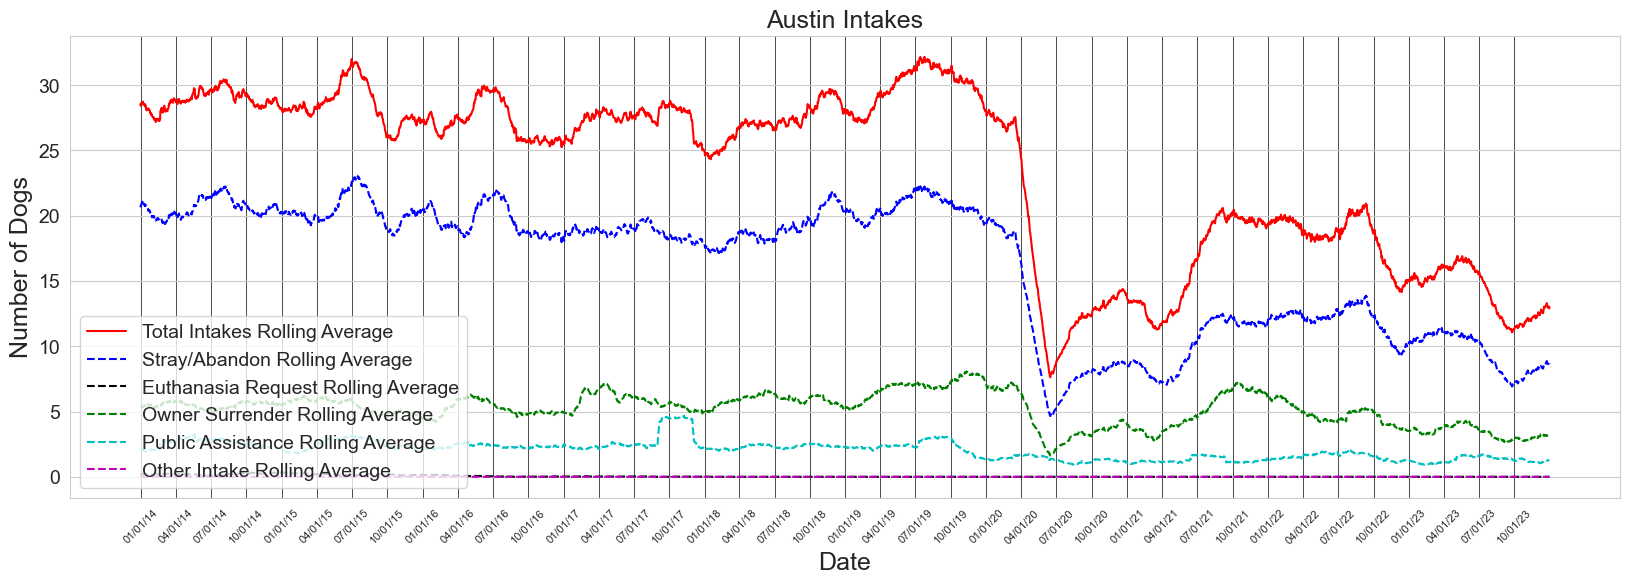

In [142]:
plt.figure(figsize=(20,6))

plt.plot(Austin_trained_intake_averages.Date, 
         Austin_trained_intake_averages.AustinIntakeTotals_rolling_avg,
         'r',
         label="Total Intakes Rolling Average")

plt.plot(Austin_trained_intake_averages.Date, 
         Austin_trained_intake_averages.stray_rolling_avg,
         'b--',
         label="Stray/Abandon Rolling Average")

plt.plot(Austin_trained_intake_averages.Date, 
         Austin_trained_intake_averages.euth_req_rolling_avg,
         'k--',
         label="Euthanasia Request Rolling Average")

plt.plot(Austin_trained_intake_averages.Date, 
         Austin_trained_intake_averages.owner_surrender_rolling_avg,
         'g--',
         label="Owner Surrender Rolling Average")

plt.plot(Austin_trained_intake_averages.Date, 
         Austin_trained_intake_averages.public_assist_rolling_avg,
         'c--',
         label="Public Assistance Rolling Average")

plt.plot(Austin_trained_intake_averages.Date, 
         Austin_trained_intake_averages.other_intake_rolling_avg,
         'm--',
         label="Other Intake Rolling Average")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Austin Intakes", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/14', end='12/31/23', freq='QS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

#### Intake Forecast

We will take the 2023 rolling averages and use those as the prediction for 2024. Since 2024 is a leap year, we will duplicate the values from February 28 and the values for February 29.

In [143]:
# copy the 2023 data
columns_to_copy = ['Date', 'stray_rolling_avg','owner_surrender_rolling_avg','public_assist_rolling_avg','other_intake_rolling_avg','AustinIntakeTotals_rolling_avg']

rows2023 = Austin_trained_intake_averages.loc[first_day23:, columns_to_copy].copy()

# add one year to the dates

rows2023['Date'] = rows2023['Date'] + pd.DateOffset(years=1)

# add in leap date
index_feb28 = rows2023[rows2023['Date'] == '2024-02-28'].index[0]
# Duplicate the row with the date '2024-02-28' and set the date to '2024-02-29'
feb29 = rows2023.loc[index_feb28].copy()
feb29['Date'] += pd.Timedelta(days=1)
rows2024 = pd.concat([rows2023.loc[:index_feb28], pd.DataFrame([feb29]), rows2023.loc[index_feb28 + 1:]])

# merge into original list

Austin_intake_averages = pd.concat([Austin_trained_intake_averages, rows2024], ignore_index=True)
print(Austin_intake_averages)


           Date  Austin_intake_stray_abandoned  stray_rolling_avg  \
0    2013-10-01                           30.0                NaN   
1    2013-10-02                           20.0                NaN   
2    2013-10-03                           19.0                NaN   
3    2013-10-04                           24.0                NaN   
4    2013-10-05                           27.0                NaN   
...         ...                            ...                ...   
4197 2024-12-27                            NaN           8.633333   
4198 2024-12-28                            NaN           8.677778   
4199 2024-12-29                            NaN           8.688889   
4200 2024-12-30                            NaN           8.800000   
4201 2024-12-31                            NaN           8.622222   

      Austin_euth_req  euth_req_rolling_avg  Austin_intake_owner_surrender  \
0                 1.0                   NaN                            9.0   
1              

Now we add in the actual data through May 15, 2024


In [144]:
# Find first day 2024

first_day24 = Austin_intake_averages[Austin_intake_averages['Date'] == '2024-01-01'].index[0]

# Check it worked
print(Austin_intake_averages.Date.iloc[first_day24])

2024-01-01 00:00:00


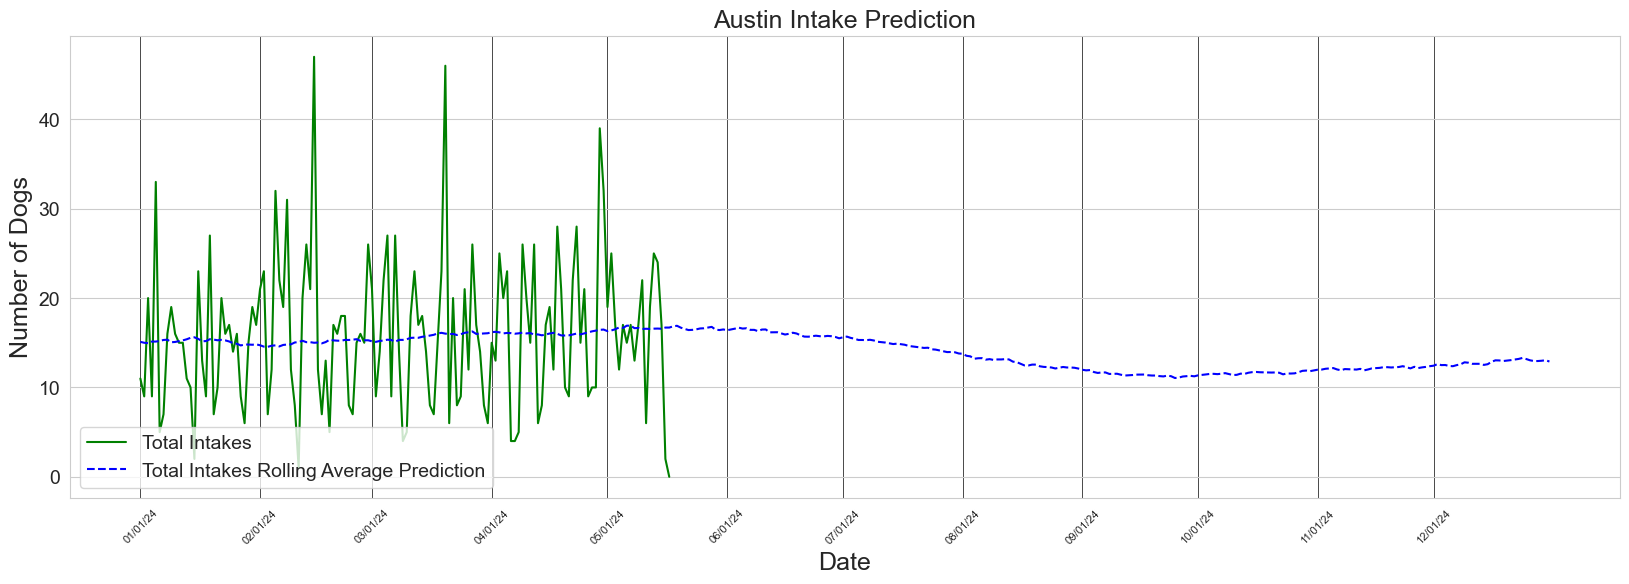

In [145]:
plt.figure(figsize=(20,6))


plt.plot(shelter_test.Date, 
         shelter_test.AustinIntakeTotal,
         'g',
         label="Total Intakes")

plt.plot(Austin_intake_averages.Date[first_day24:], 
         Austin_intake_averages.AustinIntakeTotals_rolling_avg[first_day24:],
         'b--',
         label="Total Intakes Rolling Average Prediction")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Austin Intake Prediction", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/24', end='12/31/24', freq='MS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

Since we are using root mean-squared error (RMSE) to calculate the error for the other models, we will do the same here. The since the prediction for 2024 is the rolling average values data from 2023, but we only have data through May 17, 2024, we need to find the end of the real data.


In [146]:
# There are a few more rows for Outcomes than Intakes
# We will find the last nonempty value for AustinIntakeTotals
last_nonempty_AustinIntakeTotals = shelter_test.AustinIntakeTotal.last_valid_index()

print(last_nonempty_AustinIntakeTotals)
# Now find the last date
last_date_Austin_data = shelter_test.Date[last_nonempty_AustinIntakeTotals]

print(last_date_Austin_data)

# Find the index of the same day in the rolling average data
index_last_date_Austin_ave = Austin_intake_averages.index[Austin_intake_averages['Date'] == last_date_Austin_data][0]

# Make a list of actual intake totals
# First we check that we are getting the correct dates
AustinIntakeRealDates = shelter_test.Date.loc[:last_nonempty_AustinIntakeTotals]


3881
2024-05-17 00:00:00


In [147]:
# Create the dataframe for real totals
AustinIntakeTotals_real = pd.DataFrame(shelter_test.AustinIntakeTotal.loc[:last_nonempty_AustinIntakeTotals], columns=['AustinIntakeTotal'])


# Make a list of the predicted intake totals
# First we check that we are getting the correct dates
AustinIntakePredictedDates = Austin_intake_averages.Date[first_day24:index_last_date_Austin_ave + 1]

# Then we create the predicted intake totals
AustinIntakeTotals_predicted = pd.DataFrame(Austin_intake_averages.AustinIntakeTotals_rolling_avg[first_day24:index_last_date_Austin_ave + 1], columns=['AustinIntakeTotals_rolling_avg'])

# Reset indices
AustinIntakeTotals_real.reset_index(drop=True, inplace=True)
AustinIntakeTotals_predicted.reset_index(drop=True, inplace=True)

In [148]:
# Now to calculate the RSME

# Record Rolling Average rmse's
Austin_intake_rolling_ave_rmses = np.zeros(len(AustinIntakeTotals_predicted))

for i in range(len(AustinIntakeTotals_predicted)):
    df_tt = AustinIntakeTotals_predicted.iloc[i]
    df_ho = AustinIntakeTotals_real.iloc[i]
    
    Austin_intake_rolling_ave_rmses[i] = np.sqrt(mean_squared_error(df_ho, df_tt))

print("Austin Intake Rolling Average: \n", Austin_intake_rolling_ave_rmses.mean(axis=0))

Austin Intake Rolling Average: 
 6.433735909822866


NRMSE's of models used (NRMSE = RMSE/(max - min)):

In [149]:
Austin_intake_monthly_maxmindiff = (AustinIntakeTotals_real.max(axis=0) - AustinIntakeTotals_real.min(axis=0))

print("Austin Intake Rolling Average: \n", Austin_intake_rolling_ave_rmses.mean(axis=0)/Austin_intake_monthly_maxmindiff)


Austin Intake Rolling Average: 
 AustinIntakeTotal    0.136888
dtype: float64


### Outcomes

In [150]:

Austin_trained_outcome_averages = pd.DataFrame({'Date':shelter_train.Date,
                'Austin_outcome_euthanised':shelter_train.Austin_Euth,
                  'euthanised_rolling_avg':shelter_train.Austin_Euth.rolling(90,
                                                                closed='left').mean(),
                'Austin_outcome_adoption':shelter_train.Austin_Adopt,
                  'adoption_rolling_avg':shelter_train.Austin_Adopt.rolling(90,
                                                                closed='left').mean(),
                'Austin_outcome_return_to_owner':shelter_train.Austin_RTO,
                  'return_to_owner_rolling_avg':shelter_train.Austin_RTO.rolling(90,
                                                                closed='left').mean(),
                'Austin_outcome_unintended':shelter_train.Austin_Unintended,
                  'outcome_unintended_rolling_avg':shelter_train.Austin_Unintended.rolling(90,
                                                                closed='left').mean(),
                'Austin_outcome_other':shelter_train.Austin_Other,
                  'outcome_other_rolling_avg':shelter_train.Austin_Other.rolling(90,
                                                                closed='left').mean(),
                'AustinOutcomeTotals':shelter_train.AustinOutcomeTotal,
                  'AustinOutcomeTotals_rolling_avg':shelter_train.AustinOutcomeTotal.rolling(90,
                                                                closed='left').mean()
                                                                })


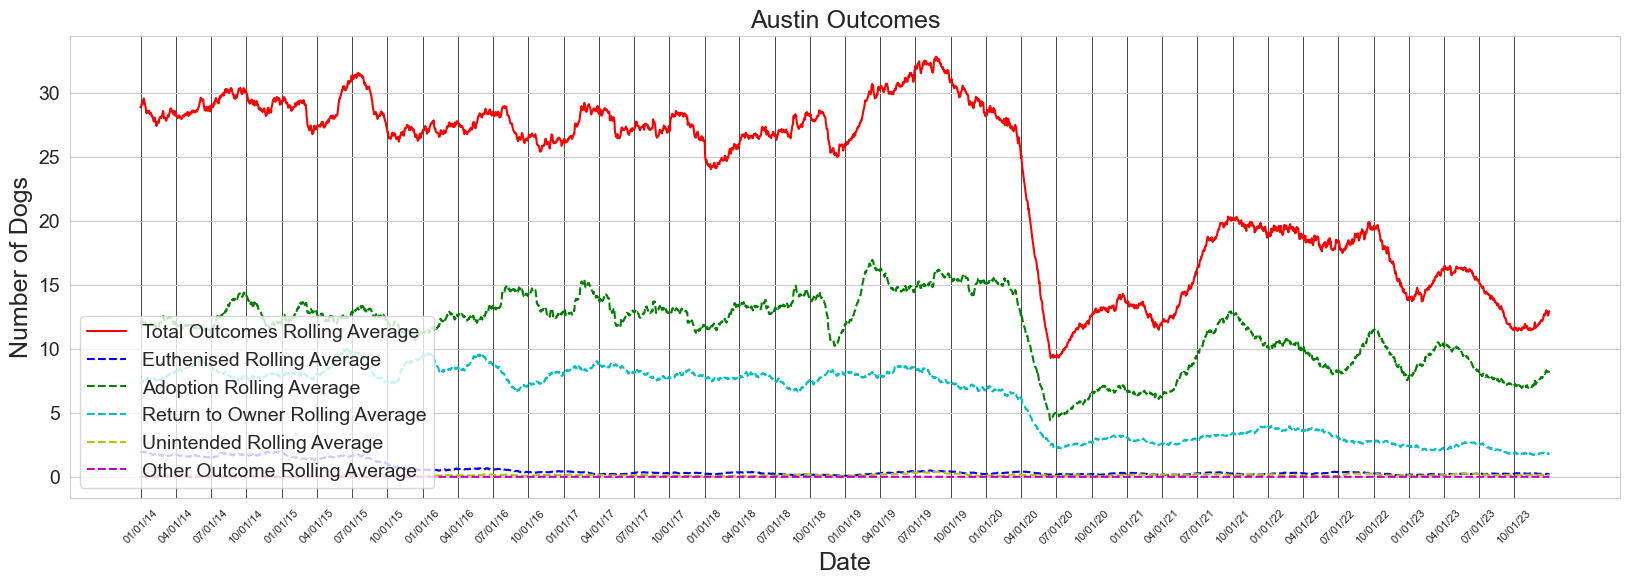

In [151]:
plt.figure(figsize=(20,6))

plt.plot(Austin_trained_outcome_averages.Date, 
         Austin_trained_outcome_averages.AustinOutcomeTotals_rolling_avg,
         'r',
         label="Total Outcomes Rolling Average")

plt.plot(Austin_trained_outcome_averages.Date, 
         Austin_trained_outcome_averages.euthanised_rolling_avg,
         'b--',
         label="Euthenised Rolling Average")

plt.plot(Austin_trained_outcome_averages.Date, 
         Austin_trained_outcome_averages.adoption_rolling_avg,
         'g--',
         label="Adoption Rolling Average")

plt.plot(Austin_trained_outcome_averages.Date, 
         Austin_trained_outcome_averages.return_to_owner_rolling_avg,
         'c--',
         label="Return to Owner Rolling Average")

plt.plot(Austin_trained_outcome_averages.Date, 
         Austin_trained_outcome_averages.outcome_unintended_rolling_avg,
         'y--',
         label="Unintended Rolling Average")

plt.plot(Austin_trained_outcome_averages.Date, 
         Austin_trained_outcome_averages.outcome_other_rolling_avg,
         'm--',
         label="Other Outcome Rolling Average")

plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Austin Outcomes", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/14', end='12/31/23', freq='QS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

#### Outcomes Forecast

We will repeat the same analysis as the intakes: duplicating the 2023 rolling averages as the prediction for 2024

In [152]:
# copy the 2023 data
columns_to_copy = ['Date', 'euthanised_rolling_avg',
                  'adoption_rolling_avg',
                  'return_to_owner_rolling_avg',
                  'outcome_unintended_rolling_avg',
                  'outcome_other_rolling_avg',
                  'AustinOutcomeTotals_rolling_avg']

rows2023 = Austin_trained_outcome_averages.loc[first_day23:, columns_to_copy].copy()

# add one year to the dates

rows2023['Date'] = rows2023['Date'] + pd.DateOffset(years=1)
# add in leap date
index_feb28 = rows2023[rows2023['Date'] == '2024-02-28'].index[0]
# Duplicate the row with the date '2024-02-28' and set the date to '2024-02-29'
feb29 = rows2023.loc[index_feb28].copy()
feb29['Date'] += pd.Timedelta(days=1)
rows2024 = pd.concat([rows2023.loc[:index_feb28], pd.DataFrame([feb29]), rows2023.loc[index_feb28 + 1:]])

# merge into original list

Austin_outcome_averages = pd.concat([Austin_trained_outcome_averages, rows2024], ignore_index=True)


In [153]:
# Find first day 2024

first_day24 = Austin_outcome_averages[Austin_outcome_averages['Date'] == '2024-01-01'].index[0]


print(Austin_outcome_averages.Date.iloc[first_day24])


2024-01-01 00:00:00


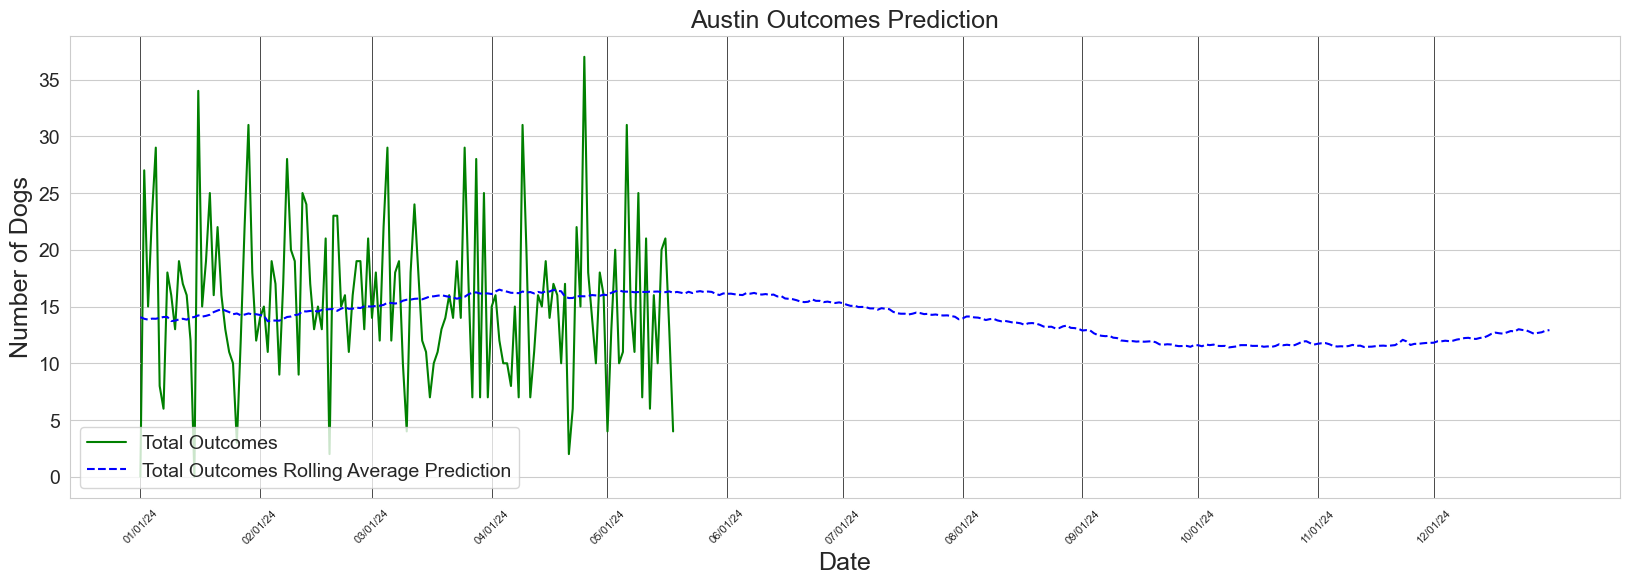

In [154]:
plt.figure(figsize=(20,6))


plt.plot(shelter_test.Date, 
         shelter_test.AustinOutcomeTotal,
         'g',
         label="Total Outcomes")

plt.plot(Austin_outcome_averages.Date[first_day24:], 
         Austin_outcome_averages.AustinOutcomeTotals_rolling_avg[first_day24:],
         'b--',
         label="Total Outcomes Rolling Average Prediction")


plt.xlabel("Date", fontsize=18)
plt.ylabel("Number of Dogs", fontsize=18)
plt.title("Austin Outcomes Prediction", fontsize=18)

# Generate major gridline positions (first of each month)
first_month = pd.date_range(start='1/1/24', end='12/31/24', freq='MS')  # Generate first of each month
major_gridline_labels = [date.strftime('%m/%d/%y') for date in first_month]

# Add gridlines with labels
plt.grid(True, which='major', axis='x', linestyle='-', linewidth='0.5', color='black')
plt.xticks(ticks=first_month, labels=major_gridline_labels, rotation=45, fontsize=8)  # Rotate and adjust fontsize as needed


plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc=3)

plt.show()

Since we are using root mean-squared error (RMSE) to calculate the error for the other models, we will do the same here. The since the prediction for 2024 is the rolling average values data from 2023, but we only have data through May 15, 2024, we need to find the end of the real data.

In [155]:
# There are a few more rows for Austin than Sonoma
# We will find the last nonempty value for SonamaIntakeTotals
last_nonempty_AustinOutcomeTotals = shelter_test.AustinOutcomeTotal.last_valid_index()

# Now find the last date

last_date_Austin_data = shelter_test.Date[last_nonempty_AustinOutcomeTotals]

# Find the index of the same day in the rolling average data
index_last_date_Austin_avg = Austin_outcome_averages.index[Austin_outcome_averages['Date'] == last_date_Austin_data][0]

# Make a list of actual intake totals
AustinOutcomeRealDates = shelter_test.Date.loc[:last_nonempty_AustinOutcomeTotals]

AustinOutcomeTotals_real = pd.DataFrame(shelter_test.AustinOutcomeTotal.loc[:last_nonempty_AustinOutcomeTotals], columns=['AustinOutcomeTotal'])

In [156]:
# Make a list of the predicted intake totals
AustinOutcomePredictedDates = Austin_outcome_averages.Date[first_day24:index_last_date_Austin_avg + 1]

# Then we create the predicted intake totals
AustinOutcomeTotals_predicted = pd.DataFrame(Austin_outcome_averages.AustinOutcomeTotals_rolling_avg[first_day24:index_last_date_Austin_avg + 1], columns=['AustinOutcomeTotals_rolling_avg'])

# Reset indices
AustinOutcomeTotals_real.reset_index(drop=True, inplace=True)
AustinOutcomeTotals_predicted.reset_index(drop=True, inplace=True)

In [157]:
# Now to calculate the RSME

# Record Rolling Average rmse's
Austin_outcome_rolling_ave_rmses = np.zeros(len(AustinOutcomeTotals_predicted))

for i in range(len(AustinOutcomeTotals_predicted)):
    df_tt = AustinOutcomeTotals_predicted.iloc[i]
    df_ho = AustinOutcomeTotals_real.iloc[i]
    
    Austin_outcome_rolling_ave_rmses[i] = np.sqrt(mean_squared_error(df_ho, df_tt))

print("Austin Outcome Rolling Average: \n", Austin_outcome_rolling_ave_rmses.mean(axis=0))


Austin Outcome Rolling Average: 
 5.522541966426858


NRMSE's of models used (NRMSE = RMSE/(max - min)):


In [158]:
Austin_outcome_monthly_maxmindiff = (AustinOutcomeTotals_real.max(axis=0) - AustinOutcomeTotals_real.min(axis=0))

print("Austin Outcome Rolling Average: \n", Austin_outcome_rolling_ave_rmses.mean(axis=0)/Austin_outcome_monthly_maxmindiff)


Austin Outcome Rolling Average: 
 AustinOutcomeTotal    0.149258
dtype: float64


# Summarizing errors

In [159]:

print("Sonoma Intake Rolling Average RMSE: \n", Sonoma_intake_rolling_ave_rmses.mean(axis=0))
print("Sonoma Intake Rolling Average NRMSE: \n", Sonoma_intake_rolling_ave_rmses.mean(axis=0)/Sonoma_intake_monthly_maxmindiff)

print("Sonoma Outcome Rolling Average RMSE: \n", Sonoma_outcome_rolling_ave_rmses.mean(axis=0))
print("Sonoma Outcome Rolling Average NRMSE: \n", Sonoma_outcome_rolling_ave_rmses.mean(axis=0)/Sonoma_outcome_monthly_maxmindiff)

print("Austin Intake Rolling Average RMSE: \n", Austin_intake_rolling_ave_rmses.mean(axis=0))
print("Austin Intake Rolling Average NRMSE: \n", Austin_intake_rolling_ave_rmses.mean(axis=0)/Austin_intake_monthly_maxmindiff)

print("Austin Outcome Rolling Average RMSE: \n", Austin_outcome_rolling_ave_rmses.mean(axis=0))
print("Austin Outcome Rolling Average NRMSE: \n", Austin_outcome_rolling_ave_rmses.mean(axis=0)/Austin_outcome_monthly_maxmindiff)


Sonoma Intake Rolling Average RMSE: 
 2.432516339869281
Sonoma Intake Rolling Average NRMSE: 
 SonomaIntakeTotals    0.093558
dtype: float64
Sonoma Outcome Rolling Average RMSE: 
 1.875
Sonoma Outcome Rolling Average NRMSE: 
 SonomaOutcomeTotals    0.1875
dtype: float64
Austin Intake Rolling Average RMSE: 
 6.433735909822866
Austin Intake Rolling Average NRMSE: 
 AustinIntakeTotal    0.136888
dtype: float64
Austin Outcome Rolling Average RMSE: 
 5.522541966426858
Austin Outcome Rolling Average NRMSE: 
 AustinOutcomeTotal    0.149258
dtype: float64
